In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [77]:
import sys
from pathlib import Path
import os
import shutil

In [3]:
sys.path.append("../fastai/")

In [4]:
from fastai.conv_learner import *

### train, val, test

In [14]:
PATH = Path("../../DATA/CUB_200_2011/")

In [82]:
paths = list(PATH.iterdir())
paths

[PosixPath('../../DATA/CUB_200_2011/classes.txt'),
 PosixPath('../../DATA/CUB_200_2011/images'),
 PosixPath('../../DATA/CUB_200_2011/train'),
 PosixPath('../../DATA/CUB_200_2011/val'),
 PosixPath('../../DATA/CUB_200_2011/image_class_labels.txt'),
 PosixPath('../../DATA/CUB_200_2011/README'),
 PosixPath('../../DATA/CUB_200_2011/images.txt'),
 PosixPath('../../DATA/CUB_200_2011/train_test_split.txt'),
 PosixPath('../../DATA/CUB_200_2011/attributes'),
 PosixPath('../../DATA/CUB_200_2011/bounding_boxes.txt'),
 PosixPath('../../DATA/CUB_200_2011/parts'),
 PosixPath('../../DATA/CUB_200_2011/test')]

In [40]:
def open_read(o): return o.open().read().strip()

In [46]:
def get_dict_from_file(fname): return {line.split(' ')[0]:line.split(' ')[1] for line in open_read(fname).split("\n")}

In [83]:
# 200 classes 
classes = get_dict_from_file(PATH/'classes.txt')

In [105]:
classes = list(classes.values())

In [84]:
# image class labels
image_cls_labels = get_dict_from_file(PATH/'image_class_labels.txt')

In [85]:
# image ids and corresponding file names
img_id_2_fname = get_dict_from_file(PATH/'images.txt')

In [86]:
# train test split - is_training
img_id_2_istrain = get_dict_from_file(PATH/'train_test_split.txt')

In [150]:
len(img_id_2_istrain)

11788

In [148]:
# train/test ratio
istrain = np.array(list(img_id_2_istrain.values()), dtype='int')

In [144]:
# move test to test folders
os.makedirs(PATH/'train', exist_ok=True)
os.makedirs(PATH/'val', exist_ok=True)
os.makedirs(PATH/'test', exist_ok=True)
for c in classes:
    os.makedirs(str(PATH/'train')+'/'+c, exist_ok=True)
    os.makedirs(str(PATH/'val')+'/'+c, exist_ok=True)
    os.makedirs(str(PATH/'test')+'/'+c, exist_ok=True)

In [145]:
train_count=0
test_count=0
for k in img_id_2_istrain:
    istrain = img_id_2_istrain[k]
    im = open_image(PATH/'images'/img_id_2_fname[k])
    if istrain == "0": # is test
        shutil.copy2(PATH/'images'/img_id_2_fname[k], PATH/'test'/img_id_2_fname[k])
        test_count+=1
    else:
        shutil.copy2(PATH/'images'/img_id_2_fname[k], PATH/'train'/img_id_2_fname[k])
        train_count+=1

In [151]:
train_count, test_count, train_count + test_count

(5994, 5794, 11788)

In [155]:
# move 0.2 of train to val
train_dirs = list((PATH/'train').iterdir())
for o in train_dirs:
    print(o.name, len(list(o.iterdir())))

In [202]:
ratio = 0.2
for o in train_dirs:
    train_files = list(o.iterdir())
    n = int(len(train_files)*ratio)
    val_files = np.random.choice(train_files, n, replace=False)
    for f in val_files: 
        shutil.move(f, PATH/'val'/o.name/f.name)

In [206]:
11788 == 5001 + 1395 + 5995 - 201*3

True

In [22]:
print(open(PATH/"README").read())

The Caltech-UCSD Birds-200-2011 Dataset

For more information about the dataset, visit the project website:

  http://www.vision.caltech.edu/visipedia

If you use the dataset in a publication, please cite the dataset in
the style described on the dataset website (see url above).

Directory Information
---------------------

- images/
    The images organized in subdirectories based on species. See 
    IMAGES AND CLASS LABELS section below for more info.
- parts/
    15 part locations per image. See PART LOCATIONS section below 
    for more info.
- attributes/
    322 binary attribute labels from MTurk workers. See ATTRIBUTE LABELS 
    section below for more info.



IMAGES AND CLASS LABELS:
Images are contained in the directory images/, with 200 subdirectories (one for each bird species)

------- List of image files (images.txt) ------
The list of image file names is contained in the file images.txt, with each line corresponding to one image:

<image_id> <image_name>
---------------

In [296]:
# test images shouldn't be under subfolders, they should be together

for o in list((PATH/'test').glob("**/*.jpg")):
    shutil.move(o, PATH/'test'/o.name)

In [323]:
for o in list((PATH/'test').glob("**/[0-9]*")):
    shutil.rmtree(o)

In [325]:
list((PATH/'test').glob("**/[0-9]*"))

[]

### look at data

In [226]:
szs = []
for o in list((PATH/'images').glob('**/*.jpg')): #https://stackoverflow.com/questions/50714469/recursively-iterate-through-all-subdirectories-using-pathlib
    szs.append(open_image(o).shape)

In [244]:
szs_dict = Counter([tuple(l) for l in np.array(szs)[:, :2].tolist()])

In [245]:
szs_dict.most_common(20)

[((333, 500), 1820),
 ((375, 500), 1192),
 ((400, 500), 366),
 ((334, 500), 364),
 ((500, 333), 305),
 ((357, 500), 239),
 ((332, 500), 235),
 ((500, 500), 205),
 ((500, 400), 166),
 ((335, 500), 157),
 ((500, 375), 144),
 ((500, 357), 89),
 ((500, 334), 89),
 ((376, 500), 72),
 ((354, 500), 60),
 ((336, 500), 59),
 ((350, 500), 57),
 ((374, 500), 57),
 ((358, 500), 56),
 ((363, 500), 53)]

### classifier

In [326]:
def get_data(sz,bs):
    tfms = tfms_from_stats(imagenet_stats, sz, aug_tfms=transforms_side_on, pad=sz//8)
    return ImageClassifierData.from_paths(PATH, trn_name='train', val_name='val', test_name='test', tfms=tfms, bs=bs)

In [327]:
data = get_data(224, 64)

In [328]:
len(data.trn_ds), len(data.val_ds), len(data.test_ds)

(4800, 1194, 5794)

In [329]:
data.c

200

In [330]:
data.classes

['001.Black_footed_Albatross',
 '002.Laysan_Albatross',
 '003.Sooty_Albatross',
 '004.Groove_billed_Ani',
 '005.Crested_Auklet',
 '006.Least_Auklet',
 '007.Parakeet_Auklet',
 '008.Rhinoceros_Auklet',
 '009.Brewer_Blackbird',
 '010.Red_winged_Blackbird',
 '011.Rusty_Blackbird',
 '012.Yellow_headed_Blackbird',
 '013.Bobolink',
 '014.Indigo_Bunting',
 '015.Lazuli_Bunting',
 '016.Painted_Bunting',
 '017.Cardinal',
 '018.Spotted_Catbird',
 '019.Gray_Catbird',
 '020.Yellow_breasted_Chat',
 '021.Eastern_Towhee',
 '022.Chuck_will_Widow',
 '023.Brandt_Cormorant',
 '024.Red_faced_Cormorant',
 '025.Pelagic_Cormorant',
 '026.Bronzed_Cowbird',
 '027.Shiny_Cowbird',
 '028.Brown_Creeper',
 '029.American_Crow',
 '030.Fish_Crow',
 '031.Black_billed_Cuckoo',
 '032.Mangrove_Cuckoo',
 '033.Yellow_billed_Cuckoo',
 '034.Gray_crowned_Rosy_Finch',
 '035.Purple_Finch',
 '036.Northern_Flicker',
 '037.Acadian_Flycatcher',
 '038.Great_Crested_Flycatcher',
 '039.Least_Flycatcher',
 '040.Olive_sided_Flycatcher',
 '

In [251]:
data.sz

224

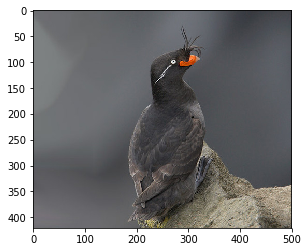

In [262]:
plt.imshow(data.trn_ds.get_x(103))

In [337]:
# original vgg 16 model
vgg_torch = vgg16_bn(False)

In [340]:
vgg_torch

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [335]:
# vgg without fc layers
vgg_model = vgg16(False)

In [336]:
vgg_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

In [332]:
# vgg with custom head layers (concat pool)
learn = ConvLearner.pretrained(vgg16, data, precompute=False,
                               pretrained=True)

In [333]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True